In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Analysis: Population-Normalized Flu Hospitalizations

In [2]:
DATA_PATH = "../analysis_data/hosps_pop_norm.csv"
VIZ_DIR = "../viz"
os.makedirs(VIZ_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])

df.head()

,date,location,location_name,population,value,season,season_week,epiyear,epiweek,weekly_rate,hosps_pop_norm
0,2020-10-24,01,Alabama,5108468,3.0,2020/2021,3,2020,43,0.058165,0.058726
1,2020-10-31,01,Alabama,5108468,18.0,2020/2021,4,2020,44,0.348993,0.352356
2,2020-11-07,01,Alabama,5108468,21.0,2020/2021,5,2020,45,0.407158,0.411082
3,2020-11-14,01,Alabama,5108468,25.0,2020/2021,6,2020,46,0.484712,0.489384
4,2020-11-21,01,Alabama,5108468,11.0,2020/2021,7,2020,47,0.213273,0.215329


In [9]:
print(df.shape)
print(df["date"].min(),df["date"].max())
print(df["location"].nunique())
print(df["season"].nunique() if "season" in df.columns else "No season column")
print(df["season_week"].min(), "to", df["season_week"].max())

df.isna().sum().sort_values(ascending=False).head(15)


(9172, 11)
2020-10-03 00:00:00 2025-12-06 00:00:00
53
6
0 to 32


date              0
location          0
location_name     0
population        0
value             0
season            0
season_week       0
epiyear           0
epiweek           0
weekly_rate       0
hosps_pop_norm    0
dtype: int64

# Distribution of normalized rates

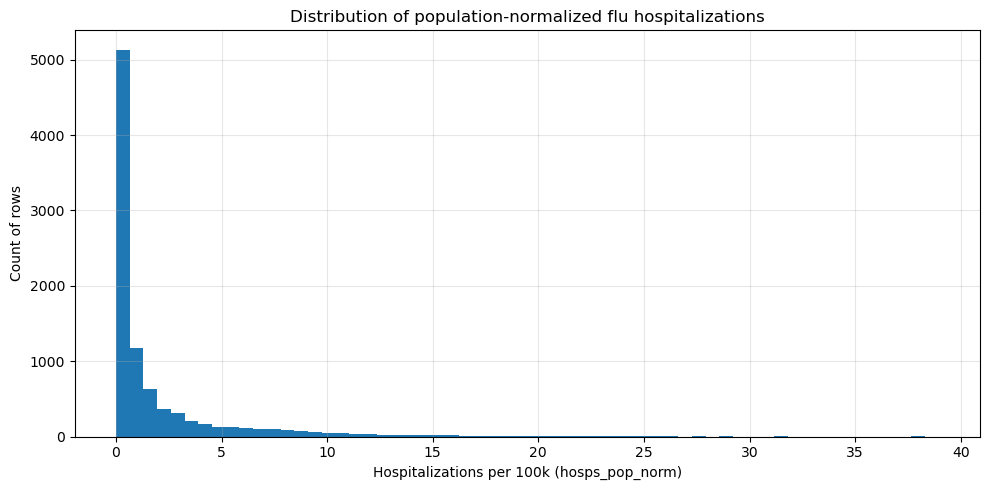

Saved: ../viz\pop_norm_distribution.png


In [10]:
plt.figure(figsize=(10,5))
plt.hist(df["hosps_pop_norm"].dropna(), bins=60)
plt.xlabel("Hospitalizations per 100k (hosps_pop_norm)")
plt.ylabel("Count of rows")
plt.title("Distribution of population-normalized flu hospitalizations")
plt.grid(alpha=0.3)
plt.tight_layout()

out = os.path.join(VIZ_DIR, "pop_norm_distribution.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


# Average flu curve across all states

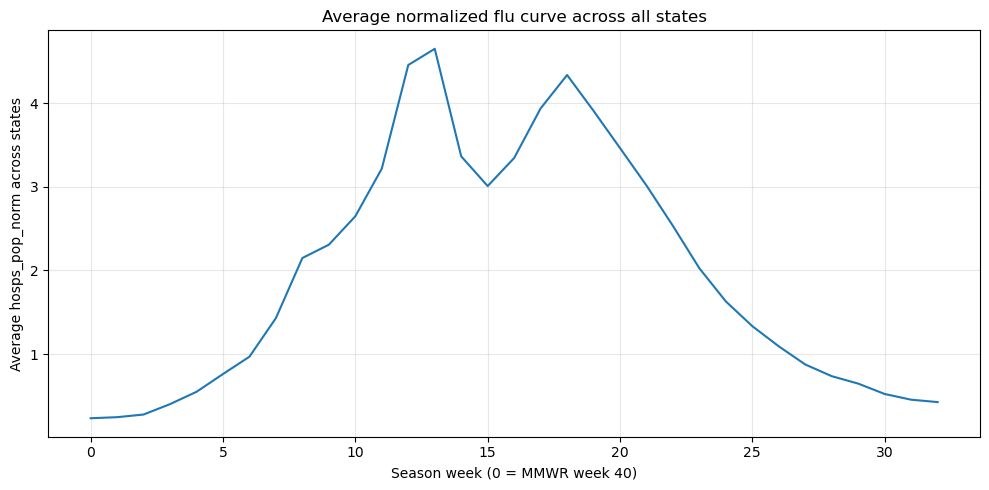

Saved: ../viz\avg_curve_all_states.png


In [11]:
avg = df.groupby("season_week")["hosps_pop_norm"].mean()

plt.figure(figsize=(10,5))
plt.plot(avg.index, avg.values)
plt.xlabel("Season week (0 = MMWR week 40)")
plt.ylabel("Average hosps_pop_norm across states")
plt.title("Average normalized flu curve across all states")
plt.grid(alpha=0.3)
plt.tight_layout()

out = os.path.join(VIZ_DIR, "avg_curve_all_states.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


## Average flu curve across all states

In this plot, we compute the average population-normalized flu hospitalization rate across all states for each season week.

Observation:
- Flu activity is usually low at the start of the season
- Hospitalizations rise steadily through early winter
- Most seasons peak between season weeks ~10–18
- Activity then declines toward the end of the season

Conclusion:  
This curve captures the “typical” flu season shape.Individual states may deviate, but the overall structure is stable.This supports the idea that flu seasons share a common underlying pattern.  

This average curve is a strong candidate for a latent flu trajectory,
which is exactly what PCA/SVD will try to uncover mathematically.


# Comparing large vs small states AFTER normalization

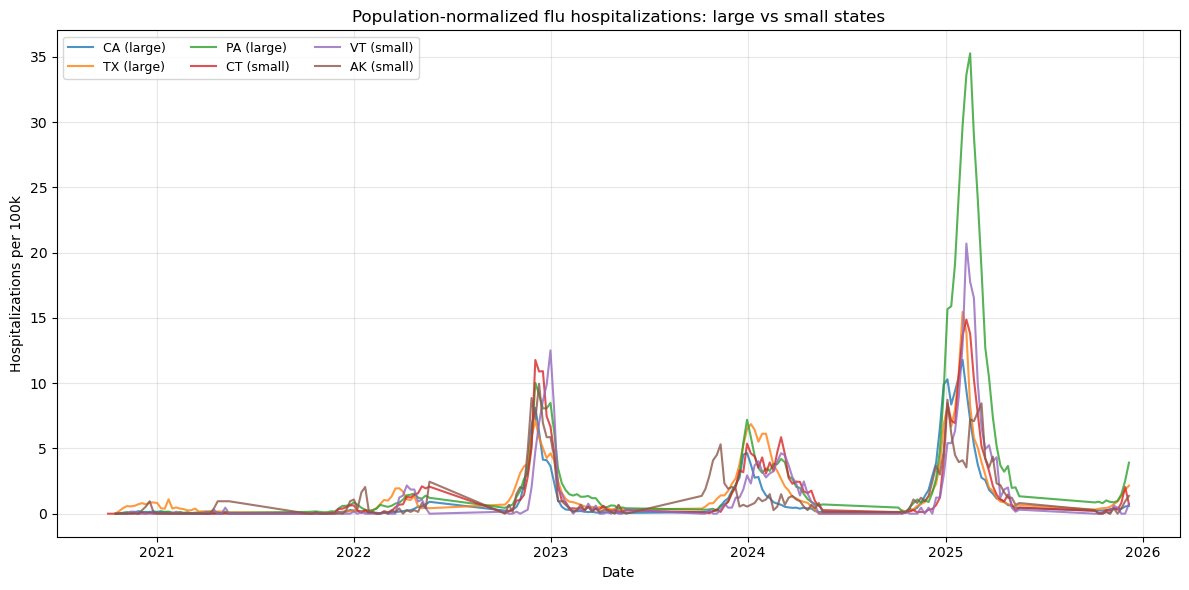

Saved: ../viz\large_vs_small_states_norm.png


In [12]:
compare = {
    "06": "CA (large)",
    "48": "TX (large)",
    "42": "PA (large)",
    "09": "CT (small)",
    "50": "VT (small)",
    "02": "AK (small)",
}

sub = df[df["location"].isin(compare.keys())].copy()

plt.figure(figsize=(12,6))
for code, label in compare.items():
    g = sub[sub["location"] == code].sort_values("date")
    plt.plot(g["date"], g["hosps_pop_norm"], label=label, alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Hospitalizations per 100k")
plt.title("Population-normalized flu hospitalizations: large vs small states")
plt.legend(ncol=3, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()

out = os.path.join(VIZ_DIR, "large_vs_small_states_norm.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


# Result
## Comparing large vs small states after population normalization

This plot compares flu hospitalization rates for:
- Large states (e.g., California, Texas)
- Small states (e.g., Alaska, Vermont)

All values are population-normalized (per 100,000 people).

Observation:
- After normalization, states are on a similar vertical scale
- Large states no longer dominate the plot.As we can see in plot:Around early 2023, Vermont (VT) reaches a peak close to 12 per 100k, which is      higher than Texas and California at the same time.
- Seasonal peaks occur at roughly the same time across states.For example:In early 2025, every state spikes together, even though:PA peaks near      35 per 100k,VT around 20 per 100k,CA and TX around 10–12 per 100k
- Differences now reflect relative flu intensity, not population size

Findings:
- Before normalization, raw hospitalization counts were misleading.  
- Population normalization allows fair comparisons across states.  
- This confirms that normalization successfully removed population effects.  

Conclusion:
After population normalization, large and small states follow the same seasonal flu pattern, but differ in intensity—confirming that flu dynamics are shared while severity varies, which motivates dimensionality-reduction via PCA/SVD.


# “Before vs after” normalization (raw vs normalized in one figure)

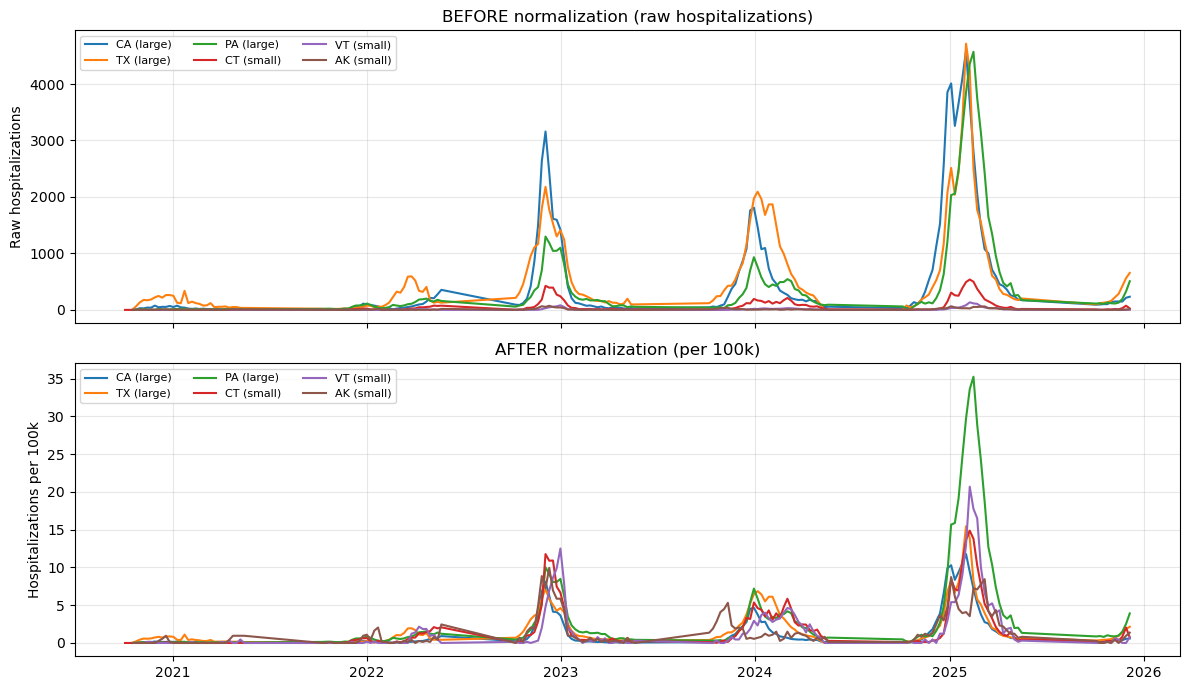

Saved: ../viz\before_after_normalization.png


In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12,7), sharex=True)

# Raw counts
for code, label in compare.items():
    g = sub[sub["location"] == code].sort_values("date")
    axes[0].plot(g["date"], g["value"], label=label)

axes[0].set_title("BEFORE normalization (raw hospitalizations)")
axes[0].set_ylabel("Raw hospitalizations")
axes[0].legend(ncol=3, fontsize=8)
axes[0].grid(alpha=0.3)

# Normalized
for code, label in compare.items():
    g = sub[sub["location"] == code].sort_values("date")
    axes[1].plot(g["date"], g["hosps_pop_norm"], label=label)

axes[1].set_title("AFTER normalization (per 100k)")
axes[1].set_ylabel("Hospitalizations per 100k")
axes[1].legend(ncol=3, fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()

out = os.path.join(VIZ_DIR, "before_after_normalization.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


## Interpreting the Before vs After Normalization Plot

This figure compares flu hospitalizations before and after population normalization for a mix of large and small states (CA, TX, PA vs CT, VT, AK).  

## Before normalization (raw hospitalizations)
In the top panel, we plot the raw number of flu hospitalizations.
Large states like Pennsylvania, California, and Texas dominate the plot.Small states such as Vermont and Alaska appear almost flat, even during severe flu seasons.
For example, in early 2025, Pennsylvania peaks above 4,500 hospitalizations, while Vermont and Alaska barely reach a few hundred.

This shows that this plot mostly reflects population size, not how severe the flu season actually was.Using raw counts makes it impossible to fairly compare states.

## After normalization (per 100,000 population)
In the bottom panel, hospitalizations are normalized by population (per 100k)
Large and small states now appear on the same scale.Seasonal peaks are clearly visible for all states.
Vermont and Alaska show meaningful flu activity that was hidden before.
For example:Vermont has a higher peak than California in early 2023.
Pennsylvania shows an exceptionally large spike in early 2025, indicating a genuinely severe season rather than just a large population.  

This shows that normalization removes population effects and reveals true flu intensity. 

**Conclusion:**  
Raw hospitalizations plot: “Which state is bigger?”  
Normalized hospitalizations plot: “Which state had a worse flu season?”  
This confirms that population normalization is necessary before comparing states or applying methods like PCA or SVD
    

# Variability across states (top 10 states by average normalized rate)

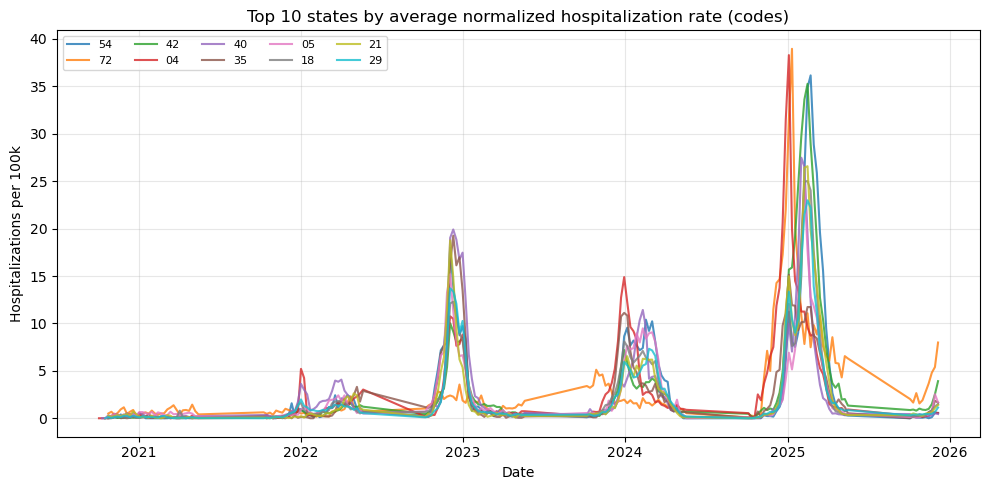

Saved: ../viz\top10_states_norm_timeseries.png


In [14]:
top_states = (
    df.groupby("location")["hosps_pop_norm"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .index
)

top = df[df["location"].isin(top_states)].copy()

plt.figure(figsize=(10,5))
for code in top_states:
    g = top[top["location"] == code].sort_values("date")
    plt.plot(g["date"], g["hosps_pop_norm"], label=code, alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Hospitalizations per 100k")
plt.title("Top 10 states by average normalized hospitalization rate (codes)")
plt.legend(ncol=5, fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()

out = os.path.join(VIZ_DIR, "top10_states_norm_timeseries.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


# Correlation heatmap

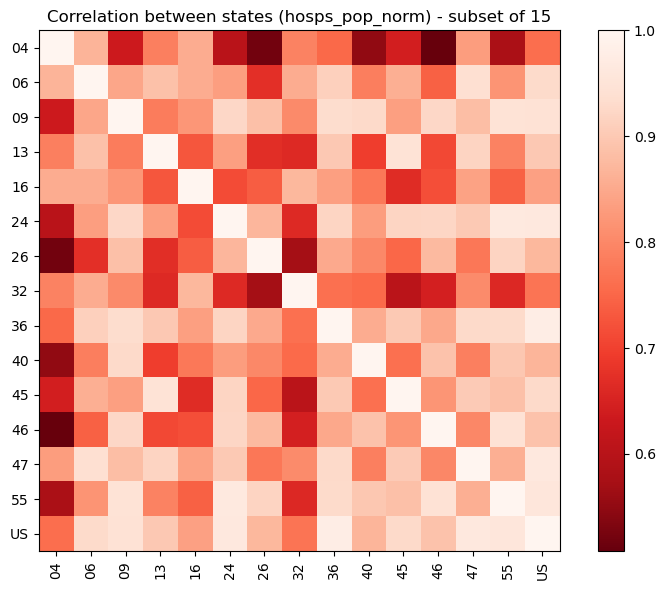

Saved: ../viz\state_correlation_subset.png


In [19]:
# Pick 15 states with most rows (robust)
state_counts = df["location"].value_counts().head(15).index.tolist()
sub15 = df[df["location"].isin(state_counts)].copy()

# Pivot: rows = season_week+season, columns = state, values = hosps_pop_norm
# Using season + season_week avoids mixing weeks across seasons incorrectly
mat = sub15.pivot_table(
    index=["season", "season_week"],
    columns="location",
    values="hosps_pop_norm",
    aggfunc="mean"
)

corr = mat.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr.values, cmap ="Reds_r")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation between states (hosps_pop_norm) - subset of 15")
plt.colorbar()
plt.tight_layout()

out = os.path.join(VIZ_DIR, "state_correlation_subset.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)


## Interpreting Correlation Heatmap
This heatmap visualizes the correlation between hospitalization rates across the 15 most frequent locations in the dataset. It measures how "in sync" the hospitalization trends are between any two states.  

Looking into this heatmap we can conclude that most states are strongly correlated

-Many state-to-state correlations are above 0.7.This means flu seasons across states tend to follow very similar shapes.Peaks and declines often happen around the same time.  

-Large states and small states are still similar in pattern.Even states with very different populations (e.g., large vs small) show high correlation.This confirms that normalization worked, population size is no longer driving the patterns.  

-Some variation still exists.A few state pairs are lighter in color.This suggests local differences in timing or severity.However, these differences are smaller than the overall shared trend.  